[*********************100%%**********************]  1 of 1 completed


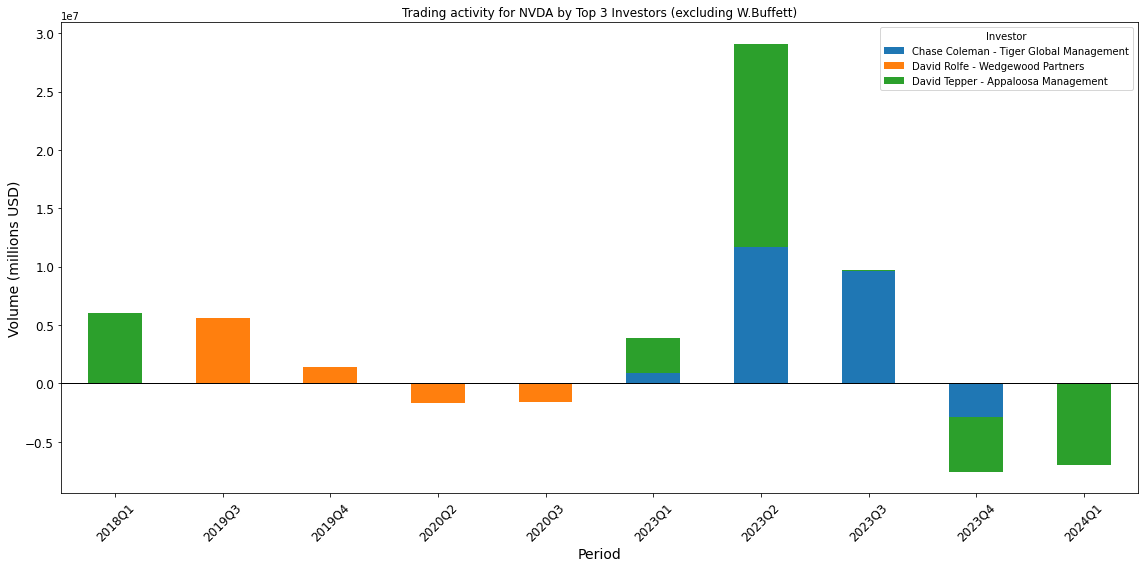

,quarter,year,share_change,transaction_type,investor_name,symbol,quarter_year,price_close,value
4,3,2023,4826800.0,buy,Chase Coleman - Tiger Global Management,NVDA,2023Q3,43.499001,209.960976
5,2,2023,5847000.0,buy,Chase Coleman - Tiger Global Management,NVDA,2023Q2,42.301998,247.339783
6,1,2023,438750.0,buy,Chase Coleman - Tiger Global Management,NVDA,2023Q1,27.777000,12.187159
7,3,2023,4826800.0,buy,Chase Coleman - Tiger Global Management,NVDA,2023Q3,43.499001,209.960976
8,2,2023,5847000.0,buy,Chase Coleman - Tiger Global Management,NVDA,2023Q2,42.301998,247.339783


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import requests

def get_quarterly_prices(symbol, years=5):
    end_date = pd.Timestamp.today()
    start_date = end_date - pd.DateOffset(years=years)
    
    stock_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
    
    if stock_data.empty:
        raise ValueError("No data found for the symbol.")
    
    quarterly_data = stock_data['Close'].resample('Q').last()
    quarterly_data = quarterly_data.reset_index()
    quarterly_data['quarter_year'] = quarterly_data['Date'].dt.to_period('Q').astype(str)
    
    return quarterly_data


def read_db_credentials(file_path):
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials


def fetch_and_visualize_symbol_activity(symbols):
    file_path = 'DB_connection.txt'
    credentials = read_db_credentials(file_path)
    connection_string = f"postgresql+psycopg2://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database']}"
    engine = create_engine(connection_string)

    query = f"""
    SELECT a.quarter, a.year, a.share_change, a.transaction_type, s.fund AS investor_name, a.symbol
    FROM activity a
    JOIN superinvestors s ON a.fund_code = s.id
    WHERE a.symbol IN ({', '.join(f"'{symbol}'" for symbol in symbols)})
    """

    df_result = pd.read_sql(query, engine)
    df_result = df_result[df_result['investor_name'] != 'Warren Buffett - Berkshire Hathaway']
    df_result['share_change'] = np.where(df_result['transaction_type'] == 'sell', -df_result['share_change'], df_result['share_change'])
    df_result['quarter_year'] = df_result['year'].astype(str) + 'Q' + df_result['quarter'].astype(str)
    df_result['price_close'] = None
    df_result['value'] = None

    for symbol in symbols:
        try:
            quarterly_prices = get_quarterly_prices(symbol)
            df_symbol = df_result[df_result['symbol'] == symbol]
            df_merged = pd.merge(df_symbol, quarterly_prices[['quarter_year', 'Close']], on='quarter_year', how='left')

            df_result.loc[df_result['symbol'] == symbol, 'price_close'] = df_merged['Close']
            df_result.loc[df_result['symbol'] == symbol, 'value'] = df_merged['Close'] * df_symbol['share_change'].abs()
        except ValueError as e:
            print(f"Error fetching data for {symbol}: {e}")

    df_result['value'] = df_result['value'] / 1_000_000
    top_investors = df_result.groupby('investor_name')['share_change'].sum().nlargest(3).index
    df_top_investors = df_result[df_result['investor_name'].isin(top_investors)]
    
    df_pivot = df_top_investors.pivot_table(values='share_change', index='quarter_year', columns='investor_name', aggfunc='sum', fill_value=0)
    ax = df_pivot.plot(kind='bar', stacked=True, figsize=(16, 8))
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'Trading activity for {", ".join(symbols)} by Top 3 Investors (excluding W.Buffett)')
    plt.xlabel('Period', fontsize=14)
    plt.ylabel('Volume (millions USD)', fontsize=14)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(axis='x', labelsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Investor', fontsize=12)   
    plt.legend(title='Investor')
    plt.tight_layout()
    plt.show()
    return df_top_investors.head()


AAA = fetch_and_visualize_symbol_activity(['NVDA'])
AAA
